# This is a gaiamock wrapper, here's how to use it

Ben Pennell

March 18th, 2025
_____

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
import pandas as pd
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 10)
import gaiamock.gaiamock as gaiamock
c_funcs = gaiamock.read_in_C_functions()
plot_dir = "./plots/"

from tqdm.notebook import tqdm
import GaiamockWrapper as gw

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
catpath = "data/m_dwarf_gaia_data.pkl"
infile = open(catpath, "rb")
r = pickle.load(infile)
infile.close()

## marginalizing ruwe

You can call `mariginalize_ruwe()` and pass in any number of keywords to then be passed into gaiamock. For every variable, there are default values so you don't need to set everything. The defaults can be seen in `calculate_ruwe()`. If you want to use values for (ra, dec, pmra, pmdec, parallax) from a catalogue, you can pass in a dataframe row to the variable `df`

Let's take an example where we specify a binary and simply see how ruwe varies. I'll leave all the other parameters to defaults (circular, face-on orbit)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07371039528078123


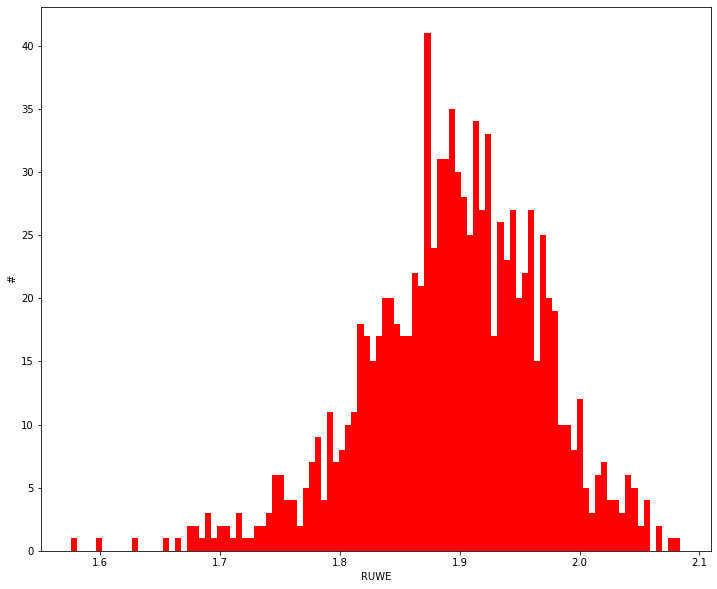

In [ ]:
ruwes = gw.marginalize_ruwe(sample_count=1000, df=r[1019], m1=0.4, q=0.1, p=1e4)
plt.hist(ruwes, bins=100, color="red");
plt.xlabel("RUWE")
plt.ylabel("#")

Now, what if we wanted to know how this $\texttt{RUWE}$ distribution changes with different primary mass? You can call `marginalize_ruwe_grid1d` and check. What you need to provide in the first argument is `([paramter name], [list of values])`

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'RUWE distribution dependence on primary mass, std shown as error bar')

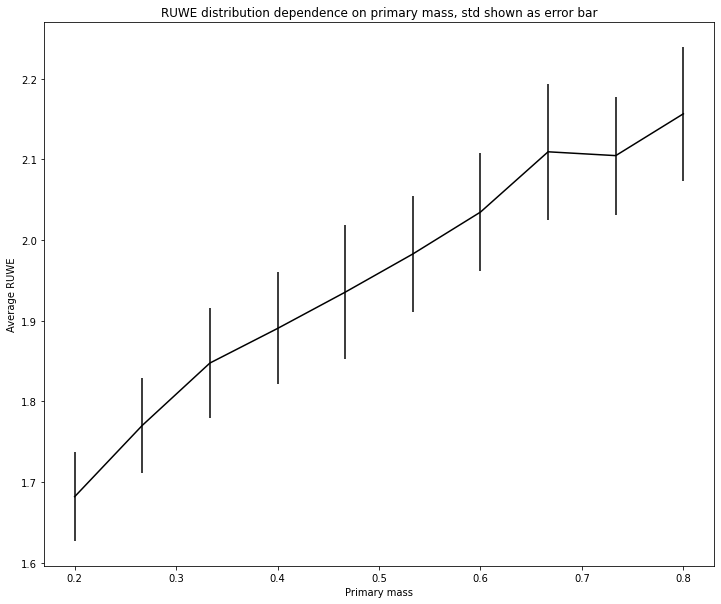

In [ ]:
m1s = np.linspace(0.2,0.8,10)
ruwes_1d = gw.marginalize_ruwe_grid1d(("m1", m1s), sample_count=100, df=r[1019], m1=0.4, q=0.1, p=1e4)
plt.errorbar(m1s, np.mean(ruwes_1d, axis=1), yerr=np.std(ruwes_1d, axis=1), color="k")
plt.xlabel("Primary mass")
plt.ylabel("Average RUWE")
plt.title("RUWE distribution dependence on primary mass, std shown as error bar")

Now, we could also check how the $\texttt{RUWE}$ distribution changed with mass AND period by calling `marginalize_ruwe_grid2d`

  0%|          | 0/108 [00:00<?, ?it/s]

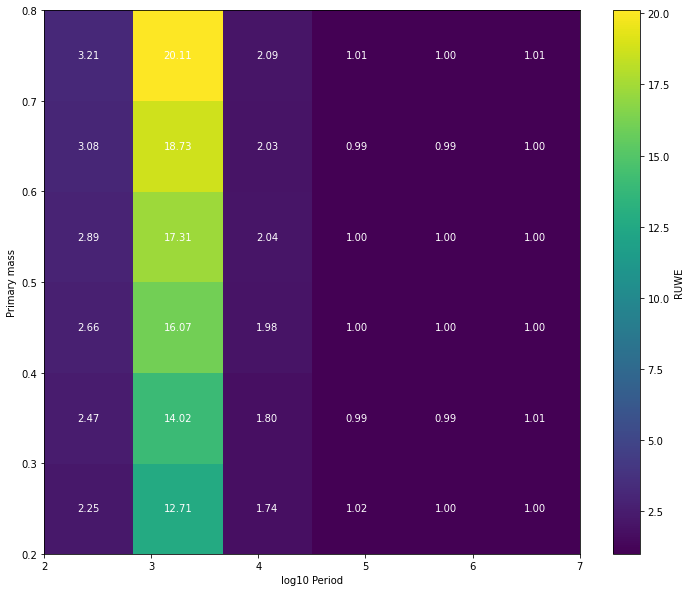

In [ ]:
m_range = (0.2,0.8)
p_range = (2,7)

m1s = np.linspace(*m_range, 6)
ps = np.logspace(*p_range,6)
ruwes_2d = gw.marginalize_ruwe_grid2d(("m1", m1s), ("period", ps), sample_count=3, df=r[1019], m1=0.4, q=0.1, p=1e4)
mean_ruwes_2d = np.mean(ruwes_2d, axis=2)

fig, ax = plt.subplots(1,1)
cb = ax.imshow(mean_ruwes_2d, extent=[p_range[0],p_range[1],m_range[1],m_range[0]], aspect="auto")
plt.colorbar(cb, label="RUWE")
ax.set_ylabel("Primary mass")
ax.set_xlabel("log10 Period")

for i in range(mean_ruwes_2d.shape[0]):
    for j in range(mean_ruwes_2d.shape[1]):
        x_pos = p_range[0] + (p_range[1] - p_range[0]) * (j + 0.5) / mean_ruwes_2d.shape[1]
        y_pos = m_range[0] + (m_range[1] - m_range[0]) * (i + 0.5) / mean_ruwes_2d.shape[0]
        
        ax.text(x_pos, y_pos, f'{mean_ruwes_2d[i, j]:.2f}', ha='center', va='center', color='white')
ax.invert_yaxis()

## Features

So, this was the basic usage. I'll now list the various other features I've included

### marginalization

If you want to marginalize over a particular parameter, you simply supply the function to be called. Currently, I haven't implemented a scheme to pass functions with arguments, but I could do this if there developed a need. So, we could marginalize over inclination with

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07675071747935987


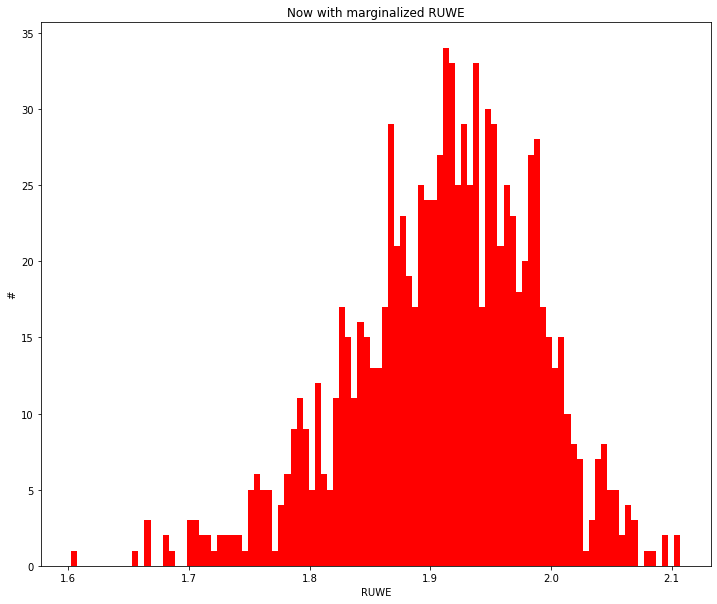

In [ ]:
def random_inc():
    return np.random.rand()*0.5*np.pi

ruwes = gw.marginalize_ruwe(sample_count=1000, df=r[1019], m1=0.4, q=0.1, p=1e4, inc=random_inc)
plt.hist(ruwes, bins=100, color="red");
plt.xlabel("RUWE")
plt.ylabel("#")
plt.title("Now with marginalized RUWE");

I've created built-in functions for marginalizing over all the orbital angles, and you can tell the program to marginalize all of them by using the keyword argument `marginalize_angles`

  0%|          | 0/1000 [00:00<?, ?it/s]

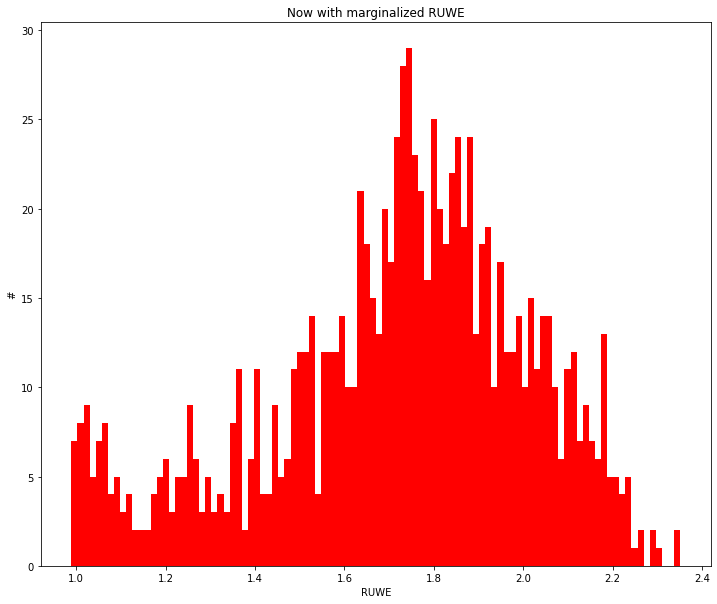

In [17]:
ruwes = gw.marginalize_ruwe(sample_count=1000, df=r[1019], m1=0.4, q=0.1, p=1e4, marginalize_angles=True)
plt.hist(ruwes, bins=100, color="red");
plt.xlabel("RUWE")
plt.ylabel("#")
plt.title("Now with marginalized RUWE");

In addition to supplying a function for marginalizing, you can specify to randomly sample from a catalogue. And, if you sample two or more parameters from a catalogue, at each step it only chooses a random row to pull all the parameters from. This prevents unphysical combinations of parameters from showing up.

To do this you need to pass in a `catalogue_path` and then specify the keyword arguments for your parameters as `"catalogue"`

  0%|          | 0/1000 [00:00<?, ?it/s]

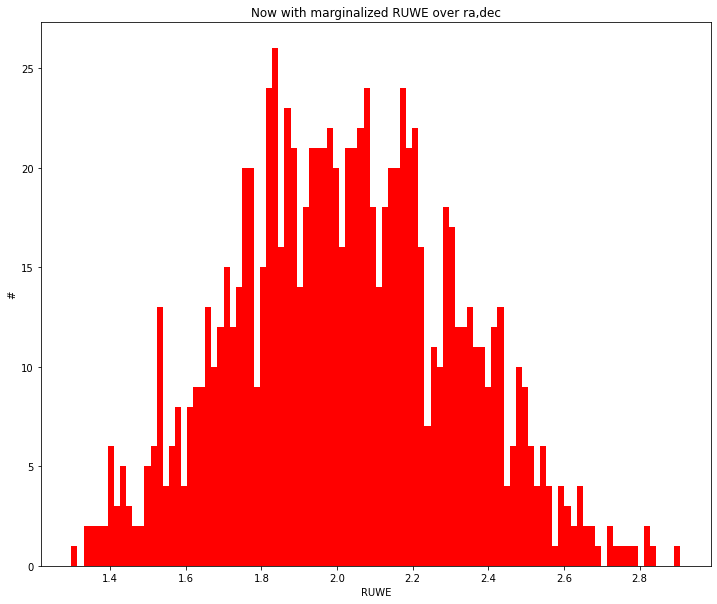

In [18]:
ruwes = gw.marginalize_ruwe(sample_count=1000, df=r[1019], catalogue_path=catpath,
                            m1=0.4, q=0.1, p=1e4, 
                            ra="catalogue", dec="catalogue")
plt.hist(ruwes, bins=100, color="red");
plt.xlabel("RUWE")
plt.ylabel("#")
plt.title("Now with marginalized RUWE over ra,dec");

there are optional keywords `marginalize_position` and `marginalize_pm` which automatically set (ra,dec) and (pmra,pmdec) to `"catalogue"` respectively. Of course, I have found that pmra and pmdec make little impact on the $\texttt{RUWE}$ distribution, so they can safely be set to 0. For this reason, their default values are zero

If you have a catalogue like the nss catalogue, you may have access to things like the eccentricity. You can tell the program to pull a given parameter from a particular row of the dataframe by passing the row to the keyword `df` and then putting in a keyword with the value `df`

In the same breath, I can mention that you can use the `use_a0` argument to calculate the astrometry using a0 instead of m1,q

  0%|          | 0/1000 [00:00<?, ?it/s]

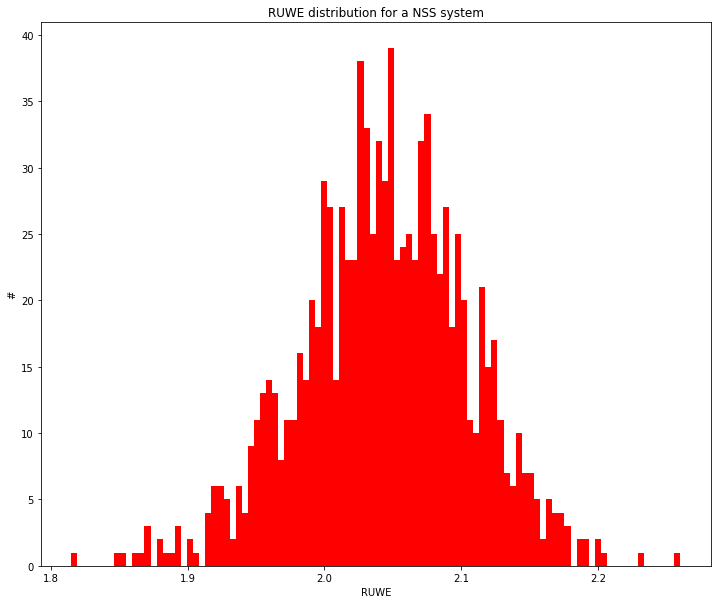

In [20]:
infile = open("data/m_dwarf_nss_data.pkl", "rb")
r_nss = pickle.load(infile)
infile.close()
ruwes = gw.marginalize_ruwe(sample_count=1000, df=r_nss[0], use_a0=True,
                            ecc="df", period="df", a0=0.5)
plt.hist(ruwes, bins=100, color="red");
plt.xlabel("RUWE")
plt.ylabel("#")
plt.title("RUWE distribution for a NSS system");

You can also use the `single_star=True` optional keyword to instead use gaiamock to calculate astrometry for a single star

If you use `marginalize_ruwe_grid1d` you can actually pass as many parameters as you'd like, they will each be computed at the same time. This could be cleverly used with a latin hypercube setup or something intelligent to aleviate the need to do higher order grid searches.

This can let me see what happens if I increase parallax and decrease q at the same time while marginalizing over the binary orientation

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'average RUWE')

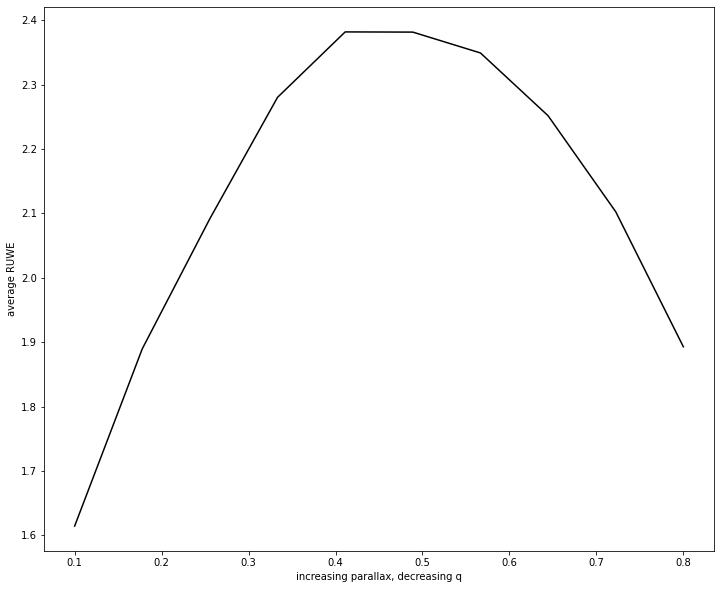

In [23]:
plaxes = np.linspace(10,30,10)
qs = np.linspace(0.8,0.1,10)
ruwes = gw.marginalize_ruwe_grid1d(("parallax", plaxes), ("q", qs), sample_count=1000, df=r[1019], marginalize_angles=True)
plt.plot(qs, np.mean(ruwes, axis=1), c="k")
plt.xlabel("increasing parallax, decreasing q")
plt.ylabel("average RUWE")

Lastly, you can get access to the values of the marginalized parameters at each step by passing in `return_parameters=True`

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'values of inclination')

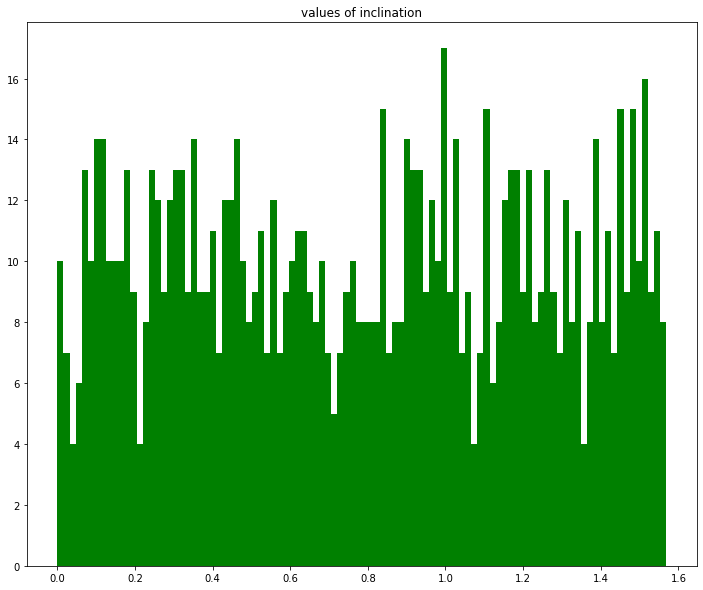

In [37]:
ruwes, params = gw.marginalize_ruwe(sample_count=1000, df=r[1019], return_params=True, inc=gw.random_inc)
plt.hist(np.array(params)[:,0], bins=100, color="green");
plt.title("values of inclination")

## Orbital Solutions

in the exact same way that you use the $\texttt{RUWE}$ marginalization functions, you can call functions to calculate the likelihood of an orbital solution to be found. I simplified the orbit solution cascade from `gaiamock` to cut all the extra information and simply return `1` if there is a 7 or 9 parameter solution, and `0` otherwise

You just need to call

`search_for_solutions`

`search_for_solutions_grid1d`

`search_for_solutions_grid2d`

I'll provide an example. Let's say I want to know how the solution finding rate changes as I move an object away from me, while marginalizing over the angles.

  0%|          | 0/3000 [00:00<?, ?it/s]

Text(0, 0.5, 'catalogue solution rate')

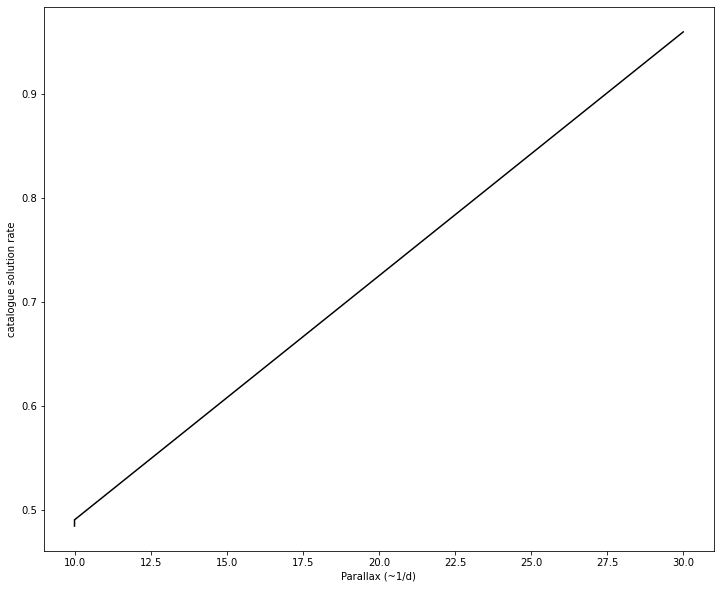

In [41]:
plaxes = (30,10,10)
solutions = gw.search_for_solutions_grid1d(("parallax", plaxes), sample_count=1000,
                                           df=r[1019], marginalize_angles=True,
                                           m1=0.8,q=0.3,period=1e4)
plt.plot(plaxes, np.mean(solutions, axis=1), c="k")
plt.xlabel("Parallax (~1/d)")
plt.ylabel("catalogue solution rate")

and I can compare to if I had just taken a face-on orbit

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0, 0.5, 'catalogue solution rate')

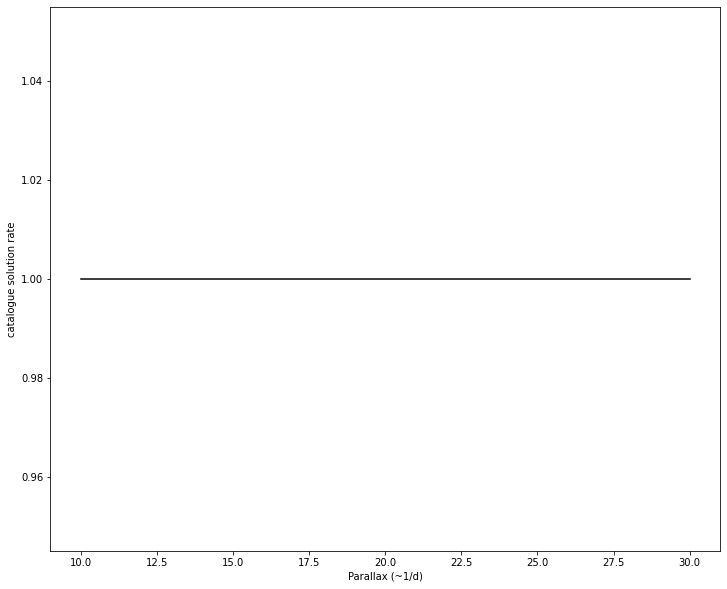

In [40]:
plaxes = (30,10,10)
solutions = gw.search_for_solutions_grid1d(("parallax", plaxes), sample_count=10,
                                           df=r[1019],
                                           m1=0.8,q=0.3,period=1e4)
plt.plot(plaxes, np.mean(solutions, axis=1), c="k")
plt.xlabel("Parallax (~1/d)")
plt.ylabel("catalogue solution rate")